<a href="https://colab.research.google.com/github/bccp/DeepUQ/blob/master/ImageCorruptionMNIST_noise075_SVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
%pylab inline
import pickle
import time

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rec', 'seed', 'var', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [26]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip
import corner

     \ 11.0MB 1.1MB/s


In [27]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

PROJ = "My Drive/BDL2019_2" 
PROJECT_PATH = os.path.join(ROOT, PROJ)
print(PROJECT_PATH)

Mounted at /content/gdrive
/content/gdrive/My Drive/BDL2019_2


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

In [0]:
generator_path   = os.path.join(PROJECT_PATH,'modules/decoder1/decoder')
encoder_path     = os.path.join(PROJECT_PATH,'modules/encoder1/encoder')
nvp_func_path    = os.path.join(PROJECT_PATH,'modules/nvp1/')
minima_path      = os.path.join(PROJECT_PATH,'minima/')
plot_path        = os.path.join(PROJECT_PATH,'plots/')

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
data_dim    = 28*28
data_size   = 1
sigma_n     = 0.1
hidden_size = 10
sample_size = 512
n_channels  = 1
seed        = 777


# settings for reconstruction with uncorrupted data
# corr_type   = 'none'
# num_mnist   = 6
# label       = 'uncorrupted'
# noise_level = 0.0
# num_comp    = 2

# settings for reconstrcution with rectangular mask
# corr_type   = 'mask'
# num_mnist   = 6
# label       = 'solidmask'
# noise_level = 0.0
# num_comp    = 5

#settings for reconstruction with sparse mask 
# corr_type   = 'sparse mask'
# num_mnist   = 1
# label       = 'sparse95'
# noise_level = 0.
# num_comp    = 2

# settings for reconstruction with noise
corr_type   = 'noise'
num_mnist   = 6
label       = 'noise075'
noise_level = 0.75
num_comp    = 3

# settings for reconstruction with noise and mask
# corr_type   = 'noise+mask'
# num_mnist   = 6
# label       = 'masknoise05'
# noise_level = 0.5
# num_comp    = 1

In [0]:
plot_path = os.path.join(plot_path,'%s/'%label)

if not os.path.isdir(plot_path):
  os.makedirs(plot_path)

In [0]:
def plot_image(image, save=True, directory='./plots/',filename='plotted_image', title='image',vmin=None,vmax=None, mask=None):
  
  if np.any(mask==None):
    mask=np.ones_like(image)
  mask = np.reshape(mask,(28,28))
  plt.figure()
  #plt.title(title)
  plt.imshow((image).reshape((28,28))*mask,cmap='gray',vmin=vmin, vmax=vmax)
  plt.axis('off')
  #plt.colorbar()
  if save: 
    plt.savefig(directory+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  return True

def get_custom_noise(shape, signal_dependent=False, signal =None, sigma_low=0.07, sigma_high=0.22, threshold=0.02 ):
  
  sigma = np.ones(shape)*sigma_n
  
  if signal_dependent: 
    for ii in range(data_size):
      sigma[ii][np.where(signal[ii]<=threshold)]= sigma_low
      sigma[ii][np.where(signal[ii]>threshold)]= sigma_high
      
  data_noise = np.ones_like(sigma)*noise_level
  
  sigma = np.sqrt(sigma**2+data_noise**2)
  
  return sigma
  

def make_corrupted_data(x_true, corr_type='mask'):
  
  mask = np.ones((28,28))
  
  if corr_type=='mask':
    
    minx = 10
    maxx = 24
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28*28))
    
    corr_data = x_true*[mask]
    
  elif corr_type=='sparse mask':
    
    mask    = np.ones(data_dim, dtype=int)
    percent = 95
    np.random.seed(seed+2)
    indices = np.random.choice(np.arange(data_dim), replace=False,size=int(percent/100.*data_dim))
    print('precentage masked:', len(indices)/data_dim)
    mask[indices] =0 
  
    corr_data = x_true*[mask]
    
  elif corr_type=='noise':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    corr_data = x_true+noise
    
  elif corr_type=='noise+mask':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    minx = 14
    maxx = 28
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28*28))
    
    corr_data = x_true+noise
    corr_data = corr_data*[mask]
    
  elif corr_type=='none':
    
    corr_data = x_true
    
  corr_data = np.expand_dims(corr_data,-1)
  
  mask = mask.flatten()
  
  return corr_data, mask

In [0]:
def fwd_pass(generator,nvp,z,mask):
  
  fwd_z           = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z},as_dict=True)['fwd_pass']

  gen_z           = tf.boolean_mask(tf.reshape(generator(fwd_z),[data_size,data_dim,n_channels]),mask, axis=1)

  return gen_z


def get_likelihood(generator,nvp,z,sigma,mask):
  
  gen_z           = fwd_pass(generator,nvp,z,mask)
  
  sigma           = tf.boolean_mask(sigma,mask, axis=1)

  likelihood      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma))

  return likelihood

def get_prior():
  
  return tfd.MultivariateNormalDiag(tf.zeros([data_size,hidden_size]), scale_identity_multiplier=1.0, name ='prior')

def get_log_posterior(z,x,generator,nvp,sigma,mask, beta):

  likelihood      = get_likelihood(generator,nvp,z,sigma,mask)
  
  prior           = get_prior()
  
  masked_x        = tf.boolean_mask(x,mask, axis=1)
  
  log_posterior   = prior.log_prob(z)+likelihood.log_prob(masked_x)*beta
  
  return log_posterior


def get_recon(generator,nvp, z,sigma,mask):
  
  prob = get_likelihood(generator,nvp, z,sigma,mask)
  
  recon= prob.mean()
  
  return recon

def get_hessian(func, z):
  
  hess             = tf.hessians(func,z)
  hess             = tf.gather(hess, 0)
  
  return(tf.reduce_sum(hess, axis = 2 ))


def get_GN_hessian(generator,nvp,z,mask,sigma):


  gen_z            = fwd_pass(generator,nvp,z,mask)
  
  sigma            = tf.boolean_mask(sigma,mask, axis=1)

  grad_g           = tf.gather(tf.gradients(gen_z/(sigma),z),0)

  grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

  one              = tf.linalg.eye(hidden_size, batch_shape=[data_size],dtype=tf.float32)

  hess_GN          = one+grad_g2
  
  return hess_GN
  
def compute_covariance(hessian):
  
  cov = tf.linalg.inv(hessian)
  
  cov = (cov+tf.linalg.transpose(cov))*0.5
  
  return cov

In [0]:
def get_neg_elbo(x,approx_posterior, generator, nvp, sigma, mask):
  
  prior          = get_prior()
  kl_divergence  = tfd.kl_divergence(approx_posterior, prior) 
  
  z_sample       = tf.reshape(approx_posterior.sample(sample_size),[-1,hidden_size])
  
  fwd_z          = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z_sample},as_dict=True)['fwd_pass']
  gen_z          = tf.boolean_mask(tf.reshape(generator(fwd_z),[sample_size,data_size,data_dim,n_channels]),mask, axis=2)
  sig            = tf.boolean_mask(sigma,mask, axis=1)

  likelihood     = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sig))

  masked_x       = tf.boolean_mask(x, mask, axis=1)
  like_prob      = likelihood.log_prob(tf.expand_dims(masked_x,0))

  elbo           = tf.reduce_mean(like_prob)- kl_divergence
  
  return -elbo

In [0]:
def minimize_neg_elbo(x,custom_mask,noise,my_sess,full_rank=False):
  
  if full_rank:
    sets = zip([1e-3,1e-4,1e-6],[4000,3000,2000])
  else:
    sets = zip([1e-3,1e-4,1e-5],[4000,2000,1000])
  
  elbo_loss = []
  start = time.time()
  for lrate, numiter in sets:
    print('lrate', lrate)
    for jj in range(numiter):
      if full_rank:
        _, ll = my_sess.run([opt_op_elbo_fr,neg_elbo_fr],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate})
      else:
        _, ll = my_sess.run([opt_op_elbo,neg_elbo],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate})
      elbo_loss.append(ll)
      if jj%1000==0:
        print('iter', jj, 'loss', ll)
        #if full_rank:
        #  print(my_sess.run([mu_vi,post_vi.covariance()],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate}))
  end= time.time()
  print('time taken',end-start)
  loss    = ll
  plt.figure()
  plt.semilogy(elbo_loss)
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.show()
  
  return True
  

In [0]:
def minimize_posterior(initial_value, x, custom_mask, noise, my_sess, annealing =True):
  
  ini = np.reshape(initial_value,[data_size,hidden_size])
  
  my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:ini, mask:custom_mask,sigma_corr:noise})
  
  pos_def = False

  start = time.time()
  posterior_loss = []
  for lrate, numiter in zip([1e-1,1e-2,1e-3],[800,500,300]):
    print('lrate', lrate)
    for jj in range(numiter):
      if annealing and lrate==1e-1:
        inv_T= np.round(0.5*np.exp(-(1.-jj/numiter)),decimals=1)
      else:
        inv_T= 1.
      _, ll = my_sess.run([opt_op_MAP,loss_MAP],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate, inverse_T:inv_T})
      posterior_loss.append(ll)
      if jj%1000==0:
        print('iter', jj, 'loss', ll,r'inverse T', inv_T)
  end = time.time()
  print('time taken',end-start)
  z_value = my_sess.run(MAP,feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise})
  
  eig     = my_sess.run(tf.linalg.eigvalsh(hessian),feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  if np.all(eig>0.):
    pos_def = True
  
  loss    = ll
  plt.figure()
  plt.semilogy(posterior_loss)
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.show()
  
  return z_value, loss, pos_def
  

In [0]:
def get_laplace_sample(num,map_value,x,mymask,noise,my_sess):
  
  my_sess.run(MAP_reset,feed_dict={MAP_ini:map_value})
  my_sess.run(update_mu)
  my_sess.run(update_TriL,feed_dict={input_data: x, mask: mymask, sigma_corr:noise})
  
  samples=[]
  for ii in range(num):
    my_sess.run(posterior_sample,feed_dict={input_data: x, sigma_corr:noise})
    samples.append(my_sess.run(recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

def get_gmm_sample(num,x,mymask,noise,my_sess):
  
  samples=[]
  for ii in range(num):
    samples.append(my_sess.run(gmm_recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

In [0]:
def plot_samples(samples, mask, title='samples', filename='samples'):
  plt.figure()
  plt.title(title)
  for i in range(min(len(samples),16)):
      subplot(4,4,i+1)
      imshow(np.reshape(samples[i,:],(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
      axis('off')
  plt.savefig(plot_path+filename+'.png',bbox_inches='tight')
  plt.show()
  
  if corr_type in ['mask', 'sparse mask', 'noise+mask']:
    plt.figure()
    plt.title('masked'+title)
    for i in range(min(len(samples),16)):
        subplot(4,4,i+1)
        imshow(np.reshape(samples[i,0,:,0]*mask,(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
        axis('off')     
    plt.savefig(plot_path+filename+'masked.png',bbox_inches='tight')
    plt.show()

In [0]:
def get_random_start_values(num, my_sess):
  result=[]
  for ii in range(num):
    result.append(my_sess.run(get_prior().sample()))
  return result

In [0]:
def get_chi2(sigma,data,mean,masking=True, mask=None,threshold=0.02):
  
  if masking:
    mask = np.reshape(mask,data.shape)
    data = data[np.where(mask==1)]
    mean = mean[np.where(mask==1)]
    sigma= sigma[np.where(mask==1)]
    
  
  low = min(sigma.flatten())
  high= max(sigma.flatten())
  
  chi2_tot = np.sum((data-mean)**2/sigma**2)
  dof_tot  = len(np.squeeze(data))
  
  if corr_type not in ['noise','noise+mask']:
    chi2_low = np.sum((data[np.where(data<=threshold)]-mean[np.where(data<=threshold)])**2/sigma[np.where(data<=threshold)]**2)
    dof_low  = len(np.squeeze(data[np.where(data<=threshold)]))
    chi2_high= np.sum((data[np.where(data>threshold)]-mean[np.where(data>threshold)])**2/sigma[np.where(data>threshold)]**2)
    dof_high = len(np.squeeze(data[np.where(data>threshold)]))
  else:
    chi2_low = None
    dof_low  = None
    chi2_high= None
    dof_high = None
  
  return chi2_tot, dof_tot, chi2_low, dof_low, chi2_high, dof_high, masking

In [0]:
def plot_minima(minima, losses, var):

  plt.figure()
  plt.title('Minimization result')
  plt.plot(np.arange(len(losses)),losses,ls='',marker='o')
  plt.xlabel('# iteration')
  plt.ylabel('loss')
  plt.savefig(plot_path+'minimzation_results_%s.png'%(label),bbox_inches='tight')
  plt.show()
  
  colors = matplotlib.colors.Normalize(vmin=min(losses), vmax=max(losses))
  cmap   = matplotlib.cm.get_cmap('Spectral')
  
  var = np.squeeze(var)
  plt.figure()
  plt.title('value of hidden variables at minima')
  for ii in range(len(minima)):
  
    yerr_= np.sqrt(var[ii])

    plt.errorbar(np.arange(hidden_size),np.squeeze(minima)[ii], marker='o',ls='', c=cmap(colors(losses[ii])), mew=0, yerr=yerr_, label ='%d'%losses[ii])
  plt.legend(ncol=4, loc=(1.01,0))
  plt.xlabel('# hidden variable')
  plt.ylabel('value')
  plt.savefig(plot_path+'hidden_values_at_minima_%s.png'%(label),bbox_inches='tight')
  plt.show()

In [0]:
def probe_posterior(minimum, x, noise, mymask, my_sess, filename=label):

  _ = my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:minimum, sigma_corr:noise})
  _ = my_sess.run(update_mu,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  _ = my_sess.run(update_TriL,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  exact_hessian = sess.run(hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  approx_hessian= sess.run(GN_hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  ll0 = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  mean_vi, sig_vi, ll0_vi = sess.run([mu_elbo,sigma_elbo, nlPost_elbo],feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  
  mean_fr, h_fr, ll0_fr   = sess.run([mu_vi,hess_fr, nlPost_vi],feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  
  print(mean_vi)
  print(minimum)
  
  print(ll0,ll0_vi,ll0_fr)
  
  plt.figure(figsize=(4*3,3))
  
  
  jj =0
  for nn in [5,6,7]:#np.arange(hidden_size):
    H    = exact_hessian[0,nn,nn]
    Hfr  = h_fr[0,nn,nn]
    H_vi = 1./sig_vi[0,nn]**2
    
    losses=[]
    
    print(H_vi,H)
    
    subplot(1,3,jj+1)
    
    title('latent space direction %d'%nn)
    
    Delta   = 0.25
    steps   = 1000
    steps_fine = 10000
    delta_z = np.zeros((steps,hidden_size))

    delta_z[:,nn] = (np.arange(steps)-steps//2)*Delta/steps
    new_ini       = delta_z+minimum
    new_ini_vi    = delta_z+mean_vi
    new_ini_fr    = delta_z+mean_fr
    
    full_span     = np.ones((steps_fine,hidden_size))*minimum
    full_span_min = min(min(new_ini_vi[:,nn]),min(new_ini[:,nn]),min(new_ini_fr[:,nn]))
    full_span_max = max(max(new_ini_vi[:,nn]),max(new_ini[:,nn]),max(new_ini_fr[:,nn]))
    full_span_    = np.linspace(full_span_min,full_span_max,steps_fine)
    full_span[:,nn]= full_span_

    for ii in range(steps_fine):
      _ = sess.run(MAP_reset,feed_dict={input_data: x, mask:mymask, MAP_ini:np.expand_dims(full_span[ii],axis=0), sigma_corr:noise})
      ll = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
      losses.append(ll)
    
  
    plt.plot(full_span[:,nn],losses,label='probed posterior', color='crimson',lw=2)
    plt.plot(new_ini[:,nn],ll0+H*delta_z[:,nn]**2,label='EL2O estimate (full rank)',lw=2)
    plt.plot(new_ini_vi[:,nn],ll0_vi+H_vi*delta_z[:,nn]**2,label='mean field SVI estimate',lw=2)
    plt.plot(new_ini_fr[:,nn],ll0_fr+Hfr*delta_z[:,nn]**2,label='full rank SVI estimate',lw=1)
    
    plt.xlabel('z',fontsize=16)
    plt.ylim(min(min(losses),ll0_fr),max(max(losses),ll0_fr+0.5))
    if jj==0:
      plt.ylabel('negative log posterior',fontsize=14)
      plt.legend(loc='best',fontsize=12,framealpha=0.9)
    jj+=1
  plt.tight_layout()
 
  
  
  
  plt.savefig(plot_path+'probing_posterior_%s.pdf'%(filename),bbox_inches='tight')
  plt.show()


In [0]:

def get_gmm_parameters(minima, x, noise, mymask, offset):
  mu   =[]
  w    =[]
  sigma=[]
  for ii in range(num_comp):

    # do Laplace approximation around this minimum
    mu+=[minima[ii]]
    sess.run(MAP_reset,feed_dict={MAP_ini:minima[ii]})
    sigma+=[sess.run(update_TriL,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})]

    # correct weighting of different minima according to El20 procedure, with samples at the maxima and well seperated maxima
    logdet  = sess.run(tf.linalg.logdet(approx_posterior_laplace.covariance()),feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    logprob = sess.run(nlPost_MAP,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    w+=[np.exp(0.5*logdet+logprob+offset)]
    
  print('weights of Gaussian mixtures:', w/np.sum(w))
  mu     = np.reshape(np.asarray(mu),[1,num_comp,hidden_size])
  sigma  = np.reshape(np.asarray(sigma),[1,num_comp,hidden_size,hidden_size])
  w      = np.squeeze(np.asarray(w))
                         
  return mu, sigma, w
                                 

In [0]:
def plot_prob_2D_GMM(samples, indices):

    samples = samples[:,0,:]

    samples = np.hstack((np.expand_dims(samples[:,indices[0]],-1),np.expand_dims(samples[:,indices[1]],-1)))

    figure=corner.corner(samples)
    axes = np.array(figure.axes).reshape((2, 2))

    axes[1,0].set_xlabel('latent space variable %d'%indices[0])
    axes[1,0].set_ylabel('latent space variable %d'%indices[1])
    plt.savefig(plot_path+'posterior_contour_GMM_%s_latent_space_dir_%d_%d.png'%(label,indices[0],indices[1]),bbox_inches='tight')
    plt.show()
    
  

In [0]:
def add_small_offset(x):
  return tf.add(x,1e-8)

In [47]:
tf.reset_default_graph()


sigma_corr  = tf.placeholder_with_default(np.ones([data_size,data_dim,n_channels], dtype='float32')*sigma_n,shape=[data_size,data_dim,n_channels])
mask        = tf.placeholder_with_default(np.ones([data_dim], dtype='float32'),shape=[data_dim])
input_data  = tf.placeholder(shape=[data_size,data_dim,n_channels], dtype=tf.float32)

inverse_T   = tf.placeholder_with_default(1., shape=[])
lr          = tf.placeholder_with_default(0.001,shape=[])

encoder     = hub.Module(encoder_path, trainable=False)
generator   = hub.Module(generator_path, trainable=False)
nvp_funcs   = hub.Module(nvp_func_path, trainable=False)

MAP_ini     = tf.placeholder_with_default(tf.zeros([data_size,hidden_size]),shape=[data_size,hidden_size])
MAP         = tf.Variable(MAP_ini)
MAP_reset   = tf.stop_gradient(MAP.assign(MAP_ini))

nlPost_MAP  = get_log_posterior(MAP, input_data, generator,nvp_funcs, sigma_corr,mask, inverse_T)
loss_MAP    = -tf.reduce_mean(nlPost_MAP)

optimizer   = tf.train.AdamOptimizer(learning_rate=lr)

opt_op_MAP  = optimizer.minimize(loss_MAP, var_list=[MAP])

recon_MAP   = get_recon(generator,nvp_funcs, MAP,sigma_corr,mask)

hessian     = get_hessian(-nlPost_MAP,MAP)

GN_hessian  = get_GN_hessian(generator,nvp_funcs,MAP,mask,sigma_corr)

ini_val  = np.ones((data_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("Laplace_Posterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((data_size,hidden_size),dtype=np.float32), dtype=np.float32)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float32)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update_mu          = mu_new.assign(MAP)
covariance         = compute_covariance(hessian)
variance           = tf.linalg.diag_part(covariance)[0]
update_TriL        = sigma_new_t2.assign(tf.linalg.cholesky(covariance))

posterior_sample   = approx_posterior_laplace.sample()

recon              = get_recon(generator,nvp_funcs, posterior_sample ,sigma_corr,mask)



########## new VI inference (think I had that before, but ok)

with tf.variable_scope("posterior_elbo_mean",reuse=tf.AUTO_REUSE):
  mu_elbo      = tf.Variable(np.zeros((data_size,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((data_size,hidden_size)), dtype=np.float32)
  
update_mu_elbo = tf.stop_gradient(mu_elbo.assign(MAP))

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')

neg_elbo       = get_neg_elbo(input_data, approx_posterior_elbo, generator, nvp_funcs, sigma_corr, mask)
opt_op_elbo    = optimizer.minimize(neg_elbo,var_list=[mu_elbo,sigma_elbo])

nlPost_elbo    = -tf.reduce_mean(get_log_posterior(mu_elbo, input_data, generator,nvp_funcs, sigma_corr,mask, 1))

 
ini_val1     = np.zeros((data_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("posterior_elbo_fullrank",reuse=tf.AUTO_REUSE):
  mu_vi      = tf.Variable(np.ones((data_size,hidden_size)), dtype=np.float32)
  sigma_vi   = tf.Variable(ini_val1)
sigma_vit    = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_vi), transform=tf.nn.softplus)
sigma_vit    = tfd.matrix_diag_transform(sigma_vit, transform=add_small_offset)
post_vi      = tfd.MultivariateNormalTriL(loc=mu_vi,scale_tril=sigma_vit)

# update_mu_vi = tf.stop_gradient(mu_vi.assign(mu_elbo))
# update_sig_vi= tf.stop_gradient(tf.linalg.set_diag(sigma_vit,sigma_elbo,name='set_diag'))

neg_elbo_fr    = get_neg_elbo(input_data, post_vi, generator, nvp_funcs, sigma_corr, mask)
opt_op_elbo_fr = optimizer.minimize(neg_elbo_fr,var_list=[mu_vi,sigma_vi])

hess_fr        = tf.linalg.inv(post_vi.covariance())
nlPost_vi      = -tf.reduce_mean(get_log_posterior(mu_vi, input_data, generator,nvp_funcs, sigma_corr,mask, 1))

recon_fr       = get_recon(generator,nvp_funcs, mu_vi ,sigma_corr,mask)
recon_elbo     = get_recon(generator,nvp_funcs, mu_elbo ,sigma_corr,mask)


# #########
ini_val2    = np.ones((data_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((data_size,num_comp,hidden_size)), dtype=np.float32)
  sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)
w_positive    = tf.math.softplus(w_gmm)
w_rescaled    = tf.squeeze(w_positive/tf.reduce_sum(w_positive))

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

mu_ini        = tf.placeholder_with_default(tf.zeros([data_size,num_comp,hidden_size]),shape=[data_size,num_comp,hidden_size])
sigma_ini     = tf.placeholder_with_default(tf.ones([data_size,num_comp,hidden_size, hidden_size]),shape=[data_size,num_comp,hidden_size, hidden_size])
w_ini         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_w      = tf.stop_gradient(w_gmm.assign(softplus_inverse(w_ini)))
update_mugmm  = tf.stop_gradient(mu_gmm.assign(mu_ini))
update_TriLgmm= tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_ini, transform=softplus_inverse)))

gmm_sample    = gmm.sample()
gmm_recon     = get_recon(generator,nvp_funcs, gmm_sample ,sigma_corr,mask)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver

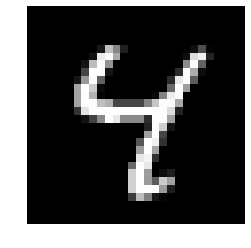

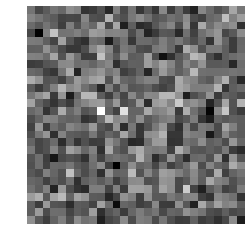

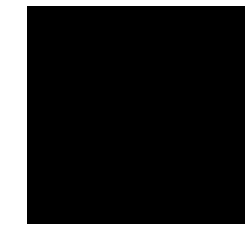

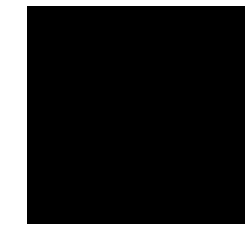

progress in % 0.0
lrate 0.1
iter 0 loss 215.06279 inverse T 0.2
lrate 0.01
iter 0 loss 932.3718 inverse T 1.0
lrate 0.001
iter 0 loss 931.9809 inverse T 1.0
time taken 11.656611442565918


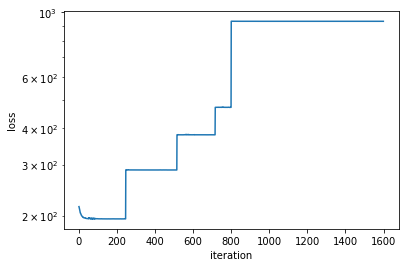

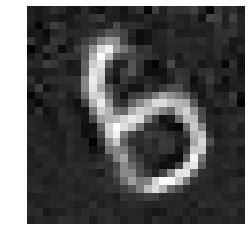

[[-1.004534   -0.2994829  -0.3435653  -0.3785887  -1.2418252   0.22760779
   0.40885204 -1.1147317   0.01970674  0.6752045 ]]
hessian postive definite
progress in % 10.0
lrate 0.1
iter 0 loss 206.88019 inverse T 0.2
lrate 0.01
iter 0 loss 921.62683 inverse T 1.0
lrate 0.001
iter 0 loss 919.07196 inverse T 1.0
time taken 10.524268627166748


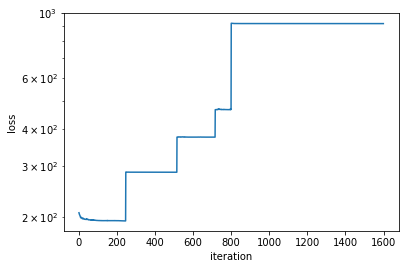

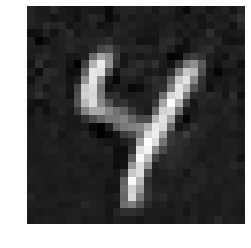

[[-0.68571067  0.01208986 -0.00810521  0.18019356 -2.316878   -0.4233664
   0.5170463  -1.4826646  -0.16520746 -0.96699417]]
hessian postive definite
progress in % 20.0
lrate 0.1
iter 0 loss 201.0207 inverse T 0.2
lrate 0.01
iter 0 loss 932.48517 inverse T 1.0
lrate 0.001
iter 0 loss 929.79767 inverse T 1.0
time taken 10.544627904891968


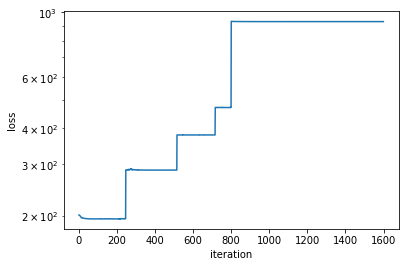

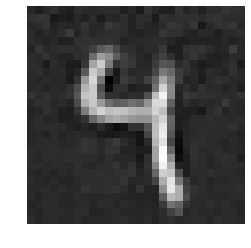

[[-0.6986159  -0.5911816   0.8285196   0.40237543 -0.44984543  0.04729616
   0.06498207 -1.3846477   1.2720016  -0.14419769]]
hessian postive definite
progress in % 30.0
lrate 0.1
iter 0 loss 206.53723 inverse T 0.2
lrate 0.01
iter 0 loss 939.3587 inverse T 1.0
lrate 0.001
iter 0 loss 938.88495 inverse T 1.0
time taken 10.730002403259277


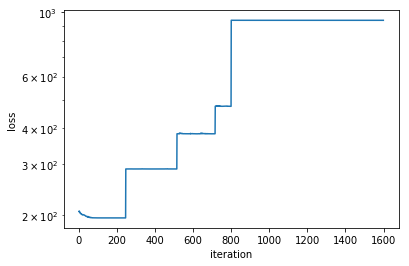

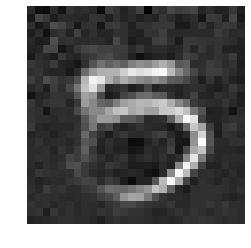

[[-0.37920243 -0.9480427  -0.38897347 -0.42210004 -0.20352335  0.755907
   0.05042778 -0.25195357  0.5880375  -0.67475665]]
hessian postive definite
progress in % 40.0
lrate 0.1
iter 0 loss 222.94379 inverse T 0.2
lrate 0.01
iter 0 loss 938.1206 inverse T 1.0
lrate 0.001
iter 0 loss 934.9516 inverse T 1.0
time taken 10.608261585235596


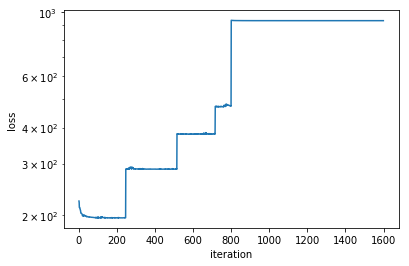

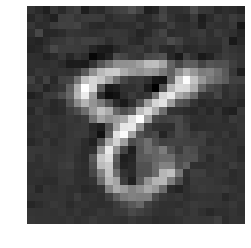

[[-0.08441019 -1.2282897  -0.27476582  0.24529108 -1.3021125   0.19328125
   0.09747222  0.56232226  0.8577325  -0.3026375 ]]
hessian postive definite
progress in % 50.0
lrate 0.1
iter 0 loss 216.66011 inverse T 0.2
lrate 0.01
iter 0 loss 933.00616 inverse T 1.0
lrate 0.001
iter 0 loss 931.9952 inverse T 1.0
time taken 10.674531936645508


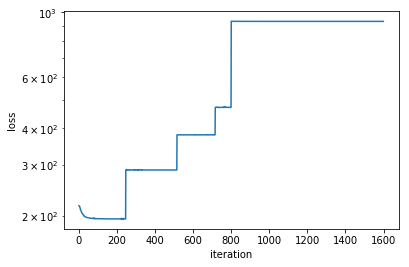

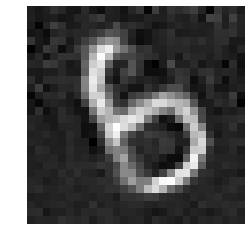

[[-9.7531128e-01 -3.3101788e-01 -3.4337863e-01 -4.0466571e-01
  -1.2164526e+00  2.1835446e-01  4.3503720e-01 -1.1345633e+00
  -8.9164398e-04  7.0717543e-01]]
hessian postive definite
progress in % 60.0
lrate 0.1
iter 0 loss 206.0193 inverse T 0.2
lrate 0.01
iter 0 loss 930.5722 inverse T 1.0
lrate 0.001
iter 0 loss 929.7973 inverse T 1.0
time taken 10.587230205535889


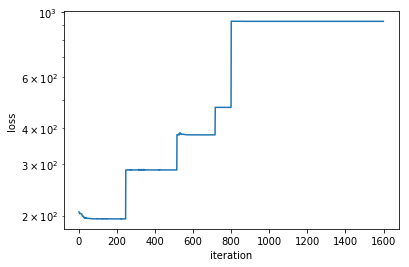

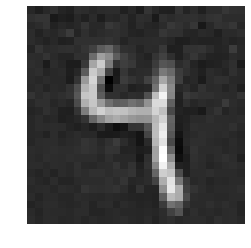

[[-0.69787425 -0.5922886   0.8284284   0.40361628 -0.45039514  0.04706774
   0.06480972 -1.3849409   1.272999   -0.14366277]]
hessian postive definite
progress in % 70.0
lrate 0.1
iter 0 loss 201.12741 inverse T 0.2
lrate 0.01
iter 0 loss 920.2774 inverse T 1.0
lrate 0.001
iter 0 loss 915.05255 inverse T 1.0
time taken 10.525010347366333


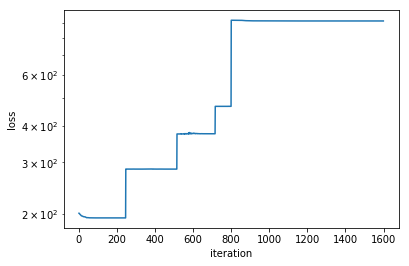

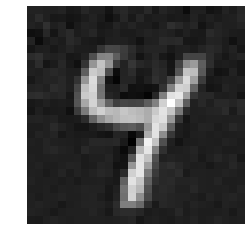

[[-0.6785777   0.4509257  -0.14013834  1.4309045  -1.9320791  -0.31719604
   0.16560383 -1.4460502   0.95983773  0.18217325]]
hessian postive definite
progress in % 80.0
lrate 0.1
iter 0 loss 203.81456 inverse T 0.2
lrate 0.01
iter 0 loss 919.5659 inverse T 1.0
lrate 0.001
iter 0 loss 918.80206 inverse T 1.0
time taken 10.52720856666565


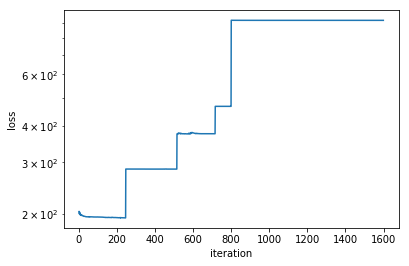

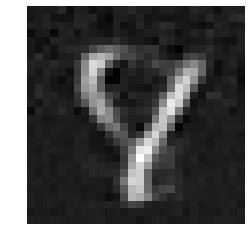

[[-0.18155546  0.15985455  0.93700004  0.65400296 -2.9365354  -0.7353926
  -0.5771705  -0.57144725 -0.6706436  -0.2883945 ]]
hessian postive definite
progress in % 90.0
lrate 0.1
iter 0 loss 208.40279 inverse T 0.2
lrate 0.01
iter 0 loss 937.36884 inverse T 1.0
lrate 0.001
iter 0 loss 936.7067 inverse T 1.0
time taken 10.509793519973755


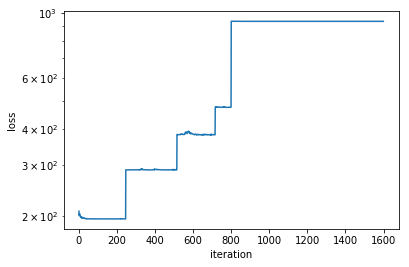

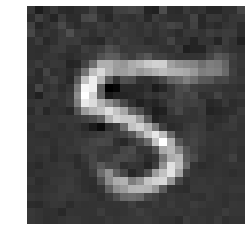

[[ 0.01967994 -0.93549246 -0.4967791   0.25745943 -1.6016374   0.3933768
   0.15958667  0.13605772 -0.26143256 -0.34266734]]
hessian postive definite


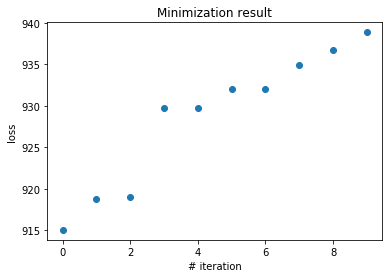

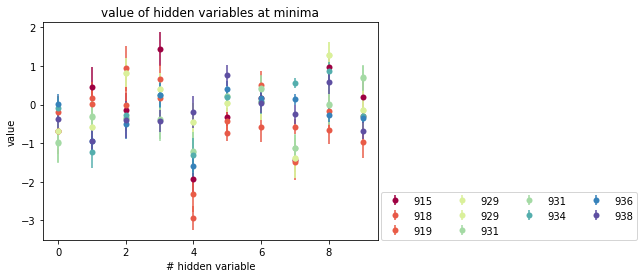

total chi2 of lowest minimum 837.1 on 784.0 pixels
lrate 0.001
iter 0 loss [963.40106]
iter 1000 loss [923.6803]
iter 2000 loss [923.90466]
iter 3000 loss [924.04504]
lrate 0.0001
iter 0 loss [923.7827]
iter 1000 loss [923.69745]
lrate 1e-05
iter 0 loss [923.2959]
time taken 128.05947041511536


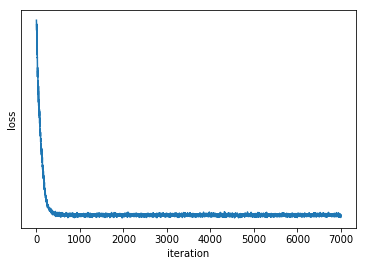

lrate 0.001
iter 0 loss [986.7976]
iter 1000 loss [934.5604]
iter 2000 loss [922.4985]
iter 3000 loss [920.8417]
lrate 0.0001
iter 0 loss [920.86383]
iter 1000 loss [920.6133]
iter 2000 loss [920.9979]
lrate 1e-06
iter 0 loss [920.64136]
iter 1000 loss [920.7491]
time taken 170.00698924064636


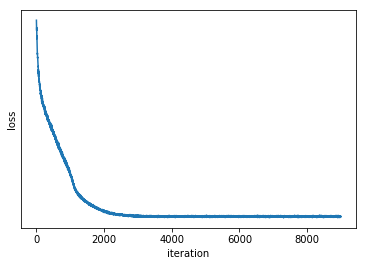

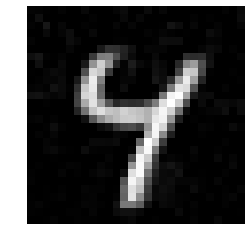

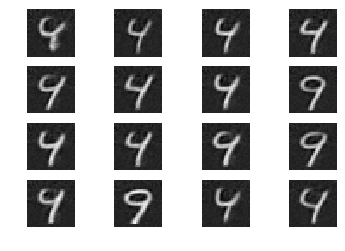

[[-0.36347932  0.4896591   0.3273266   2.0703437  -1.9706259  -0.47227472
   0.03044197 -1.4919065   1.3869475   0.10196966]]
[[-0.6785777   0.4509257  -0.14013834  1.4309045  -1.9320791  -0.31719604
   0.16560383 -1.4460502   0.95983773  0.18217325]]
915.0521 916.0661 915.8411
81.26970217460095 274.51816
21.376346154325667 14.856481
93.26402431698627 89.28465


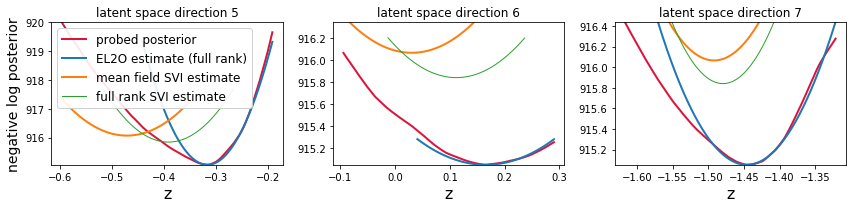

weights of Gaussian mixtures: [[0.9920438 ]
 [0.00626557]
 [0.00169058]]


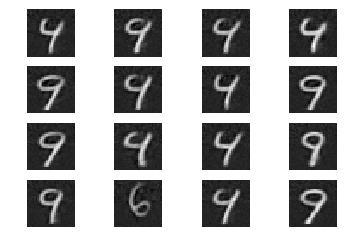

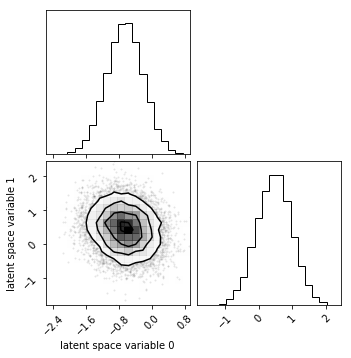

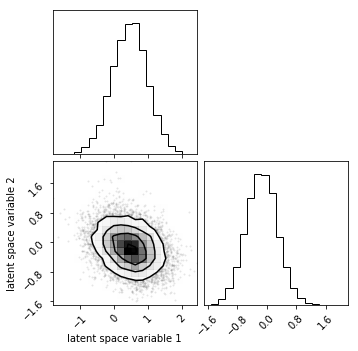

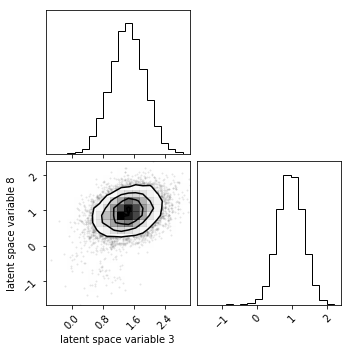

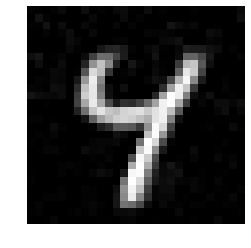

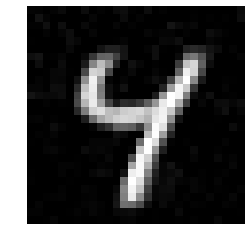

In [48]:
if __name__ == "__main__":
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  
  
  truth = x_test[num_mnist:num_mnist+data_size]
  plot_image(truth, directory=plot_path, filename='truth_%s'%label, title='truth')
  
  data, custom_mask = make_corrupted_data(truth, corr_type=corr_type)
  plot_image(data, directory=plot_path, filename='input_data_%s'%label, title='data')
  plot_image(custom_mask, directory=plot_path, filename='mask_data_%s'%label, title='mask')
  
  noise = get_custom_noise(data.shape, signal_dependent=False, signal=truth)
  plot_image(noise, directory=plot_path, filename='noise_%s'%label, title='noise')
  
  #

  

  
  tf.random.set_random_seed(seed)
  inits = get_random_start_values(10, sess)
  
  try:
    assert(False)
    minima, min_loss, min_var, recons = pickle.load(open(minima_path+'minima_%s.pkl'%label,'rb'))
  except:
  
    minima  =[]
    min_loss=[]
    min_var =[]
    recons  =[]
    for jj,init in enumerate(inits):
      print('progress in %', jj/len(inits)*100)
      min_z, min_l, pos_def    = minimize_posterior(init, data,custom_mask,noise,sess)
      rec                      = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
      var                      = sess.run(variance, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  
      plot_image(rec, directory=plot_path, filename='recon_%s_minimum%d'%(label,jj), title='reconstruction with loss %.1f'%min_l)
      print(min_z)
      if pos_def:
        print('hessian postive definite')
        minima.append(min_z)
        min_loss.append(min_l)
        min_var.append(var)
        recons.append(rec)
    
    order    = np.argsort(min_loss)
    min_loss = np.asarray(min_loss)[order]
    minima   = np.asarray(minima)[order]
    min_var  = np.asarray(min_var)[order]
    
    pickle.dump([minima, min_loss, min_var,recons],open(minima_path+'minima_%s.pkl'%label,'wb'))

  plot_minima(minima, min_loss, min_var)

  
  chi2s = get_chi2(noise,data,recons[0],masking=True, mask=custom_mask)
  
  
  print('total chi2 of lowest minimum', '%.1f'%chi2s[0], 'on', '%.1f'%chi2s[1] ,'pixels')
  try:
    print('chi2 of lowest minimum, low pixel amplitude regions', '%.1f'%chi2s[2], 'on', '%.1f'%chi2s[3], 'pixels')
    print('chi2 of lowest minimum, high pixel amplitude regions', '%.1f'%chi2s[4], 'on', '%.1f'%chi2s[5], 'pixels')
  except:
    pass
  
  lowest_minimum = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0]})
  
  sess.run(update_mu_elbo, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  minimize_neg_elbo(data,custom_mask,noise,sess)
#   sess.run(update_mu_vi, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
#   sess.run(update_sig_vi, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  minimize_neg_elbo(data,custom_mask,noise,sess, full_rank=True)  
  
  rec     = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='lowest_minimum_%s'%(label), title='reconstruction', vmin=0, vmax=1)
  if corr_type in ['mask', 'sparse mask', 'noise+mask']:
    plot_image(rec, directory=plot_path, filename='lowest_minimum_%s_masked'%(label), title='masked reconstruction', vmin=0, vmax=1, mask = custom_mask)
  samples = get_laplace_sample(16,minima[0],data,custom_mask,noise,sess)
  plot_samples(samples, custom_mask, title='Samples from Laplace approximation', filename='samples_laplace_deepest_minimum_%s'%label)
  
  probe_posterior(minima[0], data, noise, custom_mask, sess)
  
  mu_, sigma_, w_ = get_gmm_parameters([minima[0],minima[1],minima[2]], data, noise, custom_mask, min_loss[0])
  _ = sess.run([update_w, update_mugmm,update_TriLgmm], feed_dict={mu_ini:mu_, w_ini:w_, sigma_ini:sigma_ })
  
  samples = get_gmm_sample(16,data,custom_mask,noise,sess)
  plot_samples(samples, custom_mask, title='GMM samples', filename='gmm_samples_%s'%label)
  
  more_samples = []
  for ii in range(10000):
    more_samples+=[sess.run(gmm_sample,feed_dict={input_data: data, sigma_corr:noise})]
  more_samples=np.asarray(more_samples)
  
  for indices in [[0,1],[1,2],[3,8]]:
    plot_prob_2D_GMM(more_samples, indices)
  
  
  rec     = sess.run(recon_fr, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='full_rank_VI_%s'%(label), title='reconstruction', vmin=0, vmax=1)
  rec     = sess.run(recon_elbo, feed_dict={sigma_corr:noise})
  plot_image(rec, directory=plot_path, filename='mean_field_VI_%s'%(label), title='reconstruction', vmin=0, vmax=1)